In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import os
import sys
import glob
import platform
import numpy as np

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = None
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "E:\\Disk.Yandex\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"
    
elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"
    
else:
    print('unknown system', platform.platform(), platform.release())
    
sys.path.append(PACK_DIR)
from PRAO import *

In [122]:
name = '0531+21'
data = '10.09.2017'
day, month, year = data.split('.')

In [123]:
dir_file = (ALL_DATA  + name + DELIMITER + year + DELIMITER + month + year[2:] + DELIMITER)

In [124]:
files_txt = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*_profiles.txt'))
files_srez = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*.srez'))
files = np.append(files_txt, files_srez)

In [125]:
files

array(['F:\\YandexDisk\\1.Работа\\Результаты обработки\\0531+21\\2017\\0917\\100917_0531+21_00_profiles.txt'],
      dtype='<U92')

In [126]:
head, main_pulse, data_pulses, back = read_profiles_MD(files[0])

In [127]:
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

In [128]:
def flatter(data, polynomialOrder=15):
    
    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    modelPredictions = np.polyval(fittedParameters, xData)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)
    
    return yModel

### Выплащивание входных данных с использованием коэффициентов получаемых из вписывания полинома 4 степени в данные

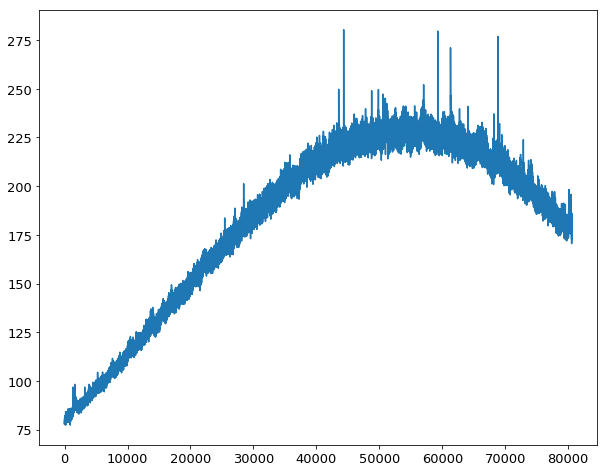

In [129]:
plt.close()
plt.plot(obser)
plt.show()

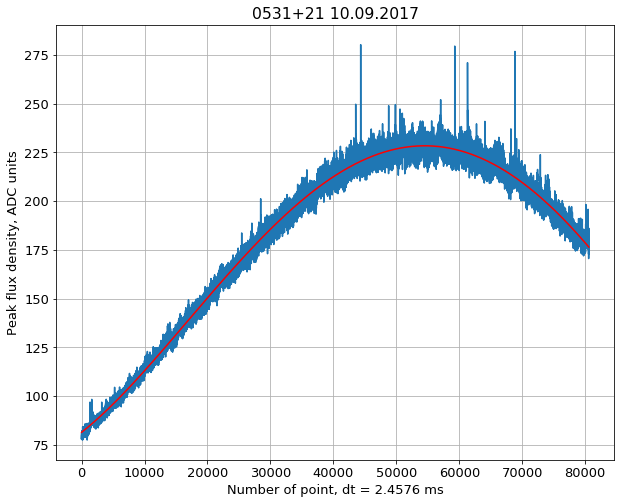

In [130]:
plt.close()
plt.rcParams.update({'font.size': 13})
plt.rcParams['figure.figsize'] = 10, 8
plt.ylabel('Peak flux density, ADC units')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.title(name + ' ' + data)
plt.plot(obser)
plt.plot(flatter(obser, 4), color='r')
plt.grid()
plt.savefig(name + '_' + data + '_teltscope.eps', format='eps', dpi=400)
# plt.show()

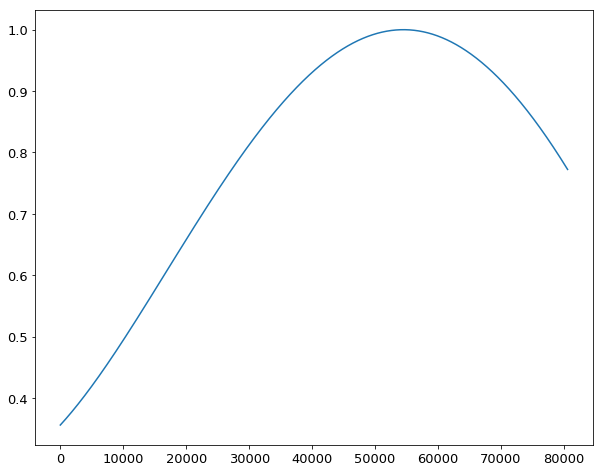

In [131]:
poli = flatter(obser, 4)
plt.close()
plt.plot(poli/max(poli))
plt.show()

In [132]:
cor_d = []
for data_point, coeff in zip(obser, poli/max(poli)):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)

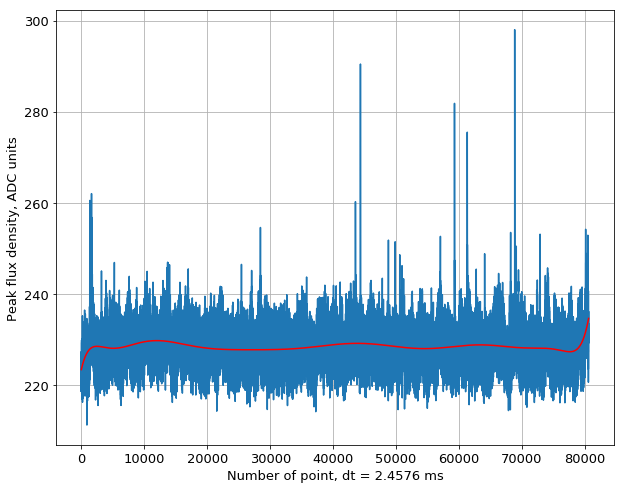

In [133]:
plt.close()
plt.rcParams.update({'font.size': 13})
plt.rcParams['figure.figsize'] = 10, 8
plt.ylabel('Peak flux density, ADC units')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.plot(cor_d)
plt.plot(flatter(cor_d, 13), color='r')
plt.grid()
plt.savefig(name + '_' + data + '_diagram.eps', format='eps', dpi=400)
# plt.show()

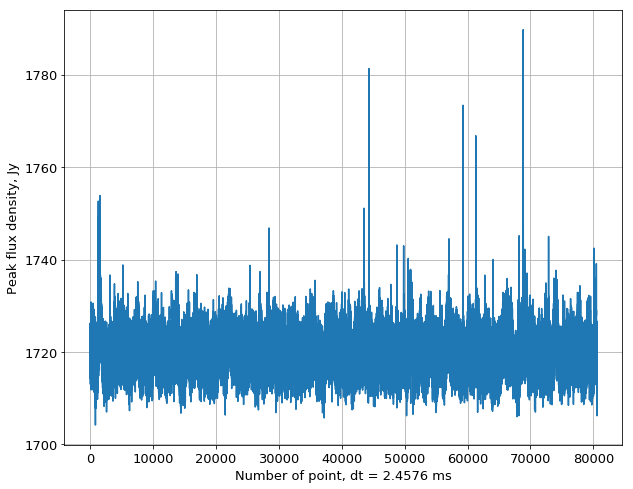

In [134]:
# вычитание полинома из данных
new_data = cor_d - flatter(cor_d, 13)
plt.close()
plt.rcParams.update({'font.size': 13})
plt.rcParams['figure.figsize'] = 10, 8
plt.ylabel('Peak flux density, Jy')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.plot(new_data + 1720)
plt.grid()
plt.savefig(name + '_' + data + '_final_polinom.eps', format='eps', dpi=400)
# plt.show()

In [135]:
x_max = np.argmax(new_data)

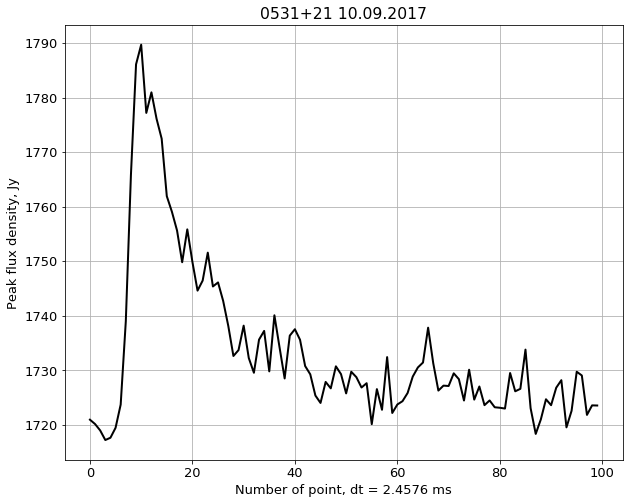

In [136]:
pulse = new_data[x_max - 10: x_max + 90] + 1720
plt.rcParams.update({'font.size': 13})
plt.rcParams['figure.figsize'] = 10, 8
plt.close()
plt.title(name + ' ' + data)
plt.ylabel('Peak flux density, Jy')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.plot(pulse, color='black', linewidth=2)
plt.grid()
#plt.axhline(np.max(pulse))
#plt.axhline(0.5*np.max(pulse))
#plt.axhline(0.1*np.max(pulse))

plt.savefig(name + '_' + data + '.eps', format='eps', dpi=1200)
#plt.show()

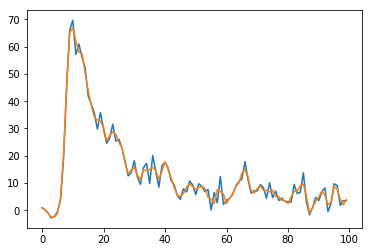

In [20]:
a = signal.savgol_filter(pulse, 5, 3)
plt.close()
plt.plot(pulse)
plt.plot(a)
plt.show()